In [ ]:
pip install tensorflow

In [1]:
import json
import time
import warnings
import cmath
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

2022-12-27 11:15:21.183756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 11:15:21.336375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-27 11:15:21.336407: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-27 11:15:22.248279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

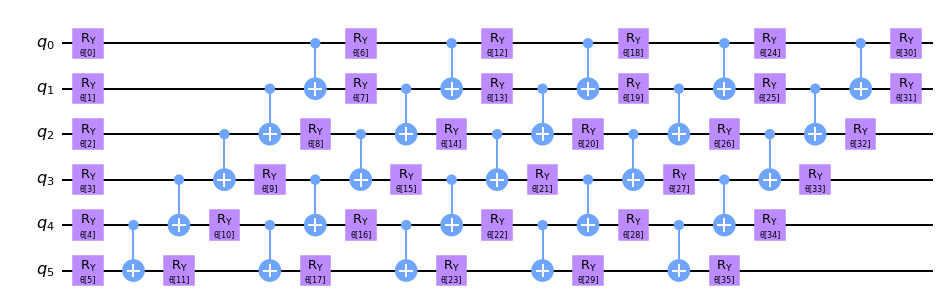

In [19]:
num_qubits = 6
circ = ansatz(num_qubits)
circ.decompose().draw("mpl")

In [3]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

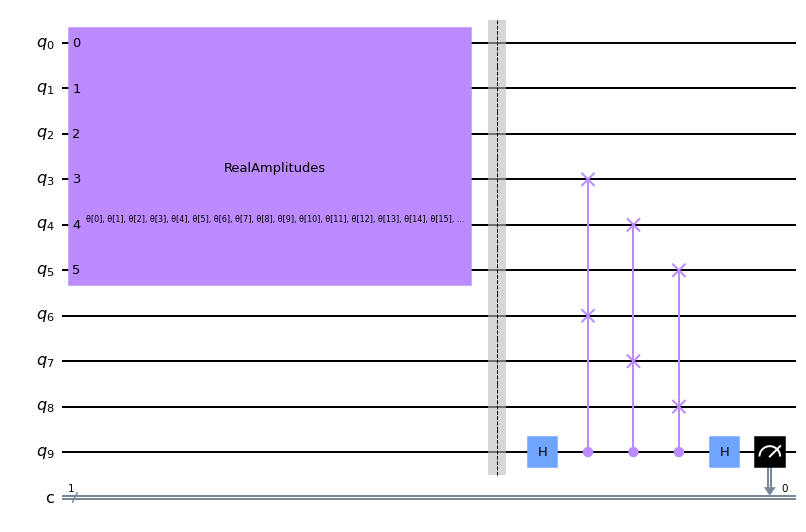

In [20]:
num_latent = 3
num_trash = 3
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw("mpl")

In [4]:
# data preprocessing ...

In [5]:
#Loading the MNIST set divided by a train set and a test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

#Showing the length of the train and test sets
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

#Function to filter the 0 and 1 labels of the MNIST set
'''
Input = x_label and y_label sets
Output = x_label and y_label sets filtered
'''
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    return x,y

x_train, y_train = filter_01(x_train, y_train) #Filter the train set
x_test, y_test = filter_01(x_test, y_test) #Filter the test set

#Showing the length of the train and test sets after filtering the data
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

Number of images in the training set: 60000
Number of images in the test set: 10000
Number of images in the training set: 12665
Number of images in the test set: 2115


2022-12-27 11:15:42.705482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-27 11:15:42.705525: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-27 11:15:42.705554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-63a9a6b5cb5c9b79523a8d1c): /proc/driver/nvidia/version does not exist
2022-12-27 11:15:42.705872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


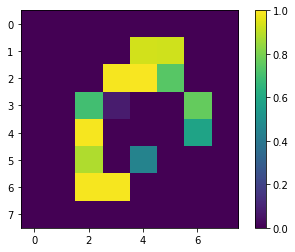

In [6]:
#resizing the image from 28x28 to 8x8 by the nearest method
x_train_small = tf.image.resize(x_train, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_small = tf.image.resize(x_test, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

#Plotting the first element of the train set after the resizing
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [7]:
#Reshaping the train and test test to a 64x1 matriz
x_train = x_train_small.reshape(len(x_train_small), 64)
x_test = x_test_small.reshape(len(x_test_small), 64)

In [8]:
#Deleting no valuable information for the training set
k = 0 

while k < len(x_train):
    a = x_train[k].copy() #make a copy of the actual element
    #Verfify if it has some valuable data
    if np.sum(a) == 0.: 
        #If not has valuable data
        print(k,x_train[k]) 
        x_train = np.delete(x_train, k, axis=0) #Delete the actual element from the x_label
        y_train = np.delete(y_train, k, axis=0) #Delete the actual element from the y_label
        k -= 1 #Take back one value of the counter to match the new set length
    k+=1

In [9]:
#Deleting no valuable information for the test set
k = 0

while k < len(x_test): #Deleting no valuable information for the training set
    a = x_test[k].copy()
    #Verfify if it has some valuable data
    if np.sum(a) == 0.:
        #If not has valuable data
        print(k,x_test[k])
        x_test = np.delete(x_test, k, axis=0) #Delete the actual element from the x_label
        y_test = np.delete(y_test, k, axis=0) #Delete the actual element from the y_label
        k -= 1 #Take back one value of the counter to match the new set length
    k+=1

In [10]:
#Funtion to normalize the data of an array
'''
Input = Array with n values
Output = Array with normalized valued
'''
def Normalize(row):
    #We calculate the squareroot of the sum of the square values of the row
    suma = np.sqrt(np.sum(row**2)) 
    if suma == 0.:
        #If the sum is zero we return a 0
        return 0.0
    #Else we divide each value between the sum value above
    row = row/suma
    return row 

#Normalize the training set data
for i in range(len(x_train)):
    x_train[i] = Normalize(x_train[i])

#Normalize the test set data
for i in range(len(x_test)):
    x_test[i] = Normalize(x_test[i])
    
#Showing the state sum of the training set    
print("The sum of the states from the training set 0",np.sum(x_train[0]**2))

The sum of the states from the training set 0 1.0


In [11]:
train_images = x_train[0:100]
train_labels = y_train[0:100]
test_images = x_test[0:100]
test_labels = y_test[0:100]

In [12]:
# end of data preprocessing ...

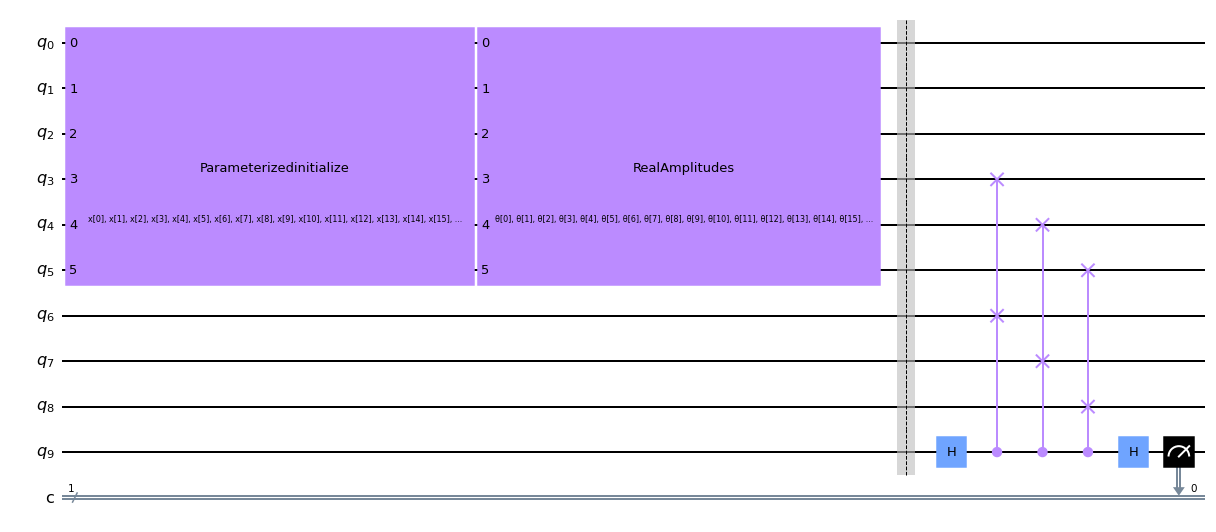

In [13]:
num_latent = 3
num_trash = 3

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw("mpl")

In [14]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [15]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

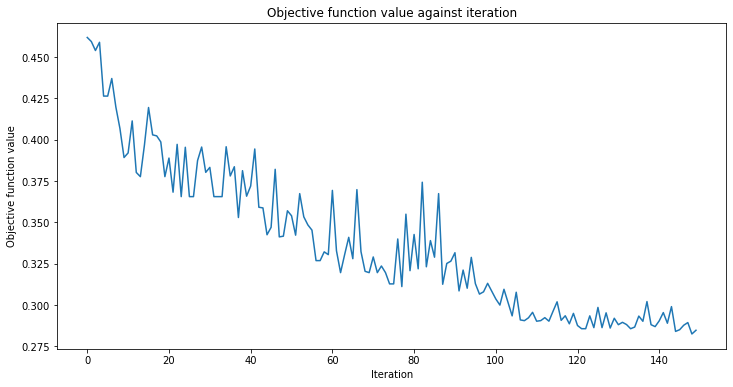

Fit in 5707.87 seconds


In [16]:
# note: this cell did not run!
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

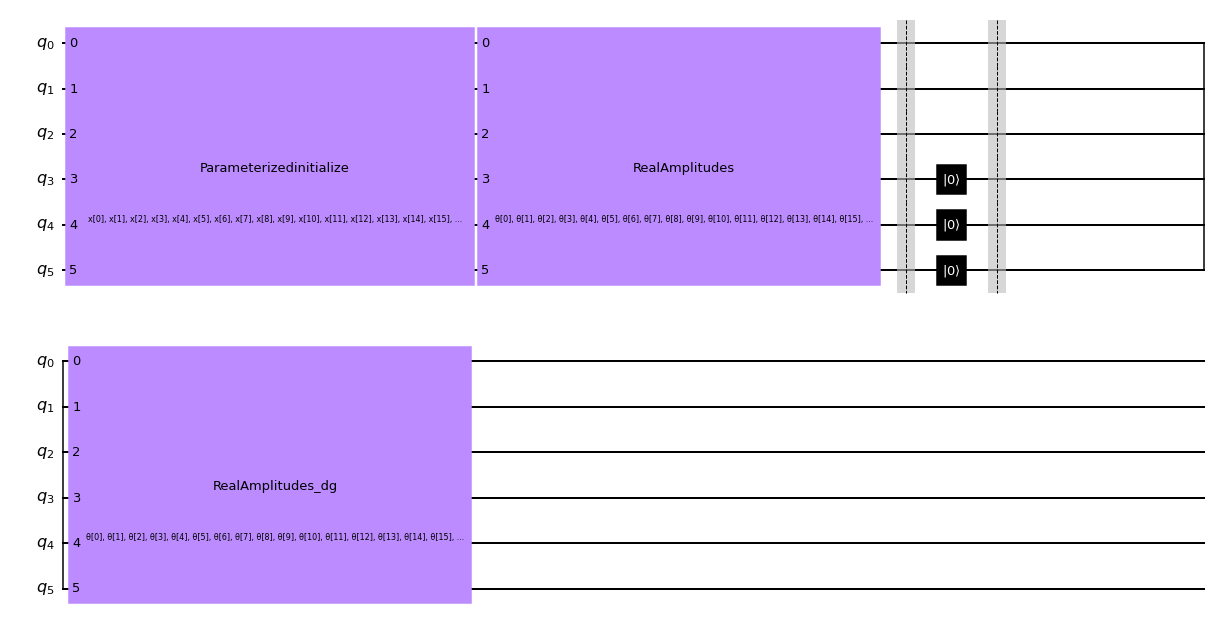

In [21]:
# Testing circuit
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(5)
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())
test_qc.draw("mpl")

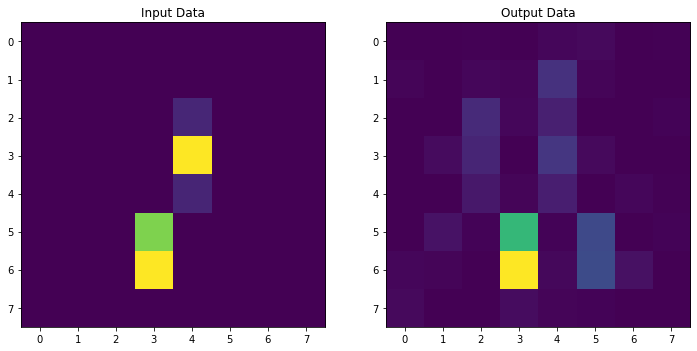

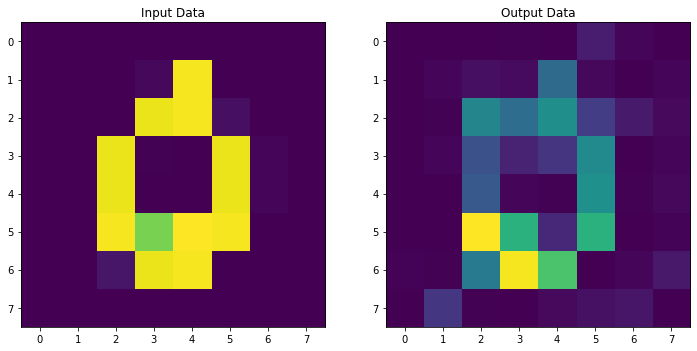

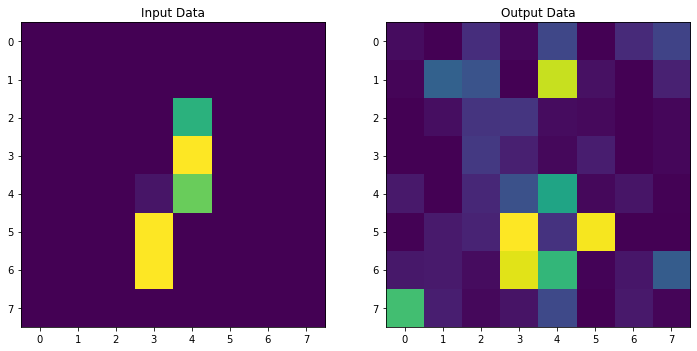

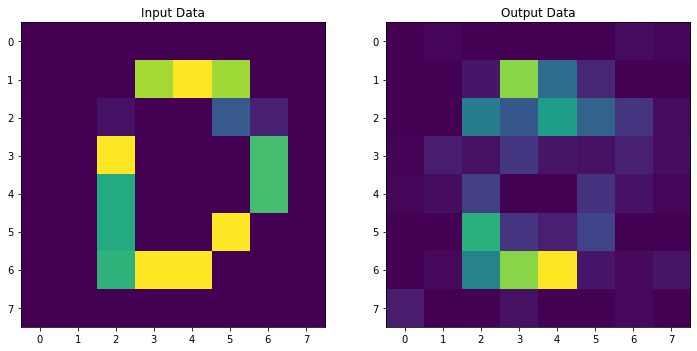

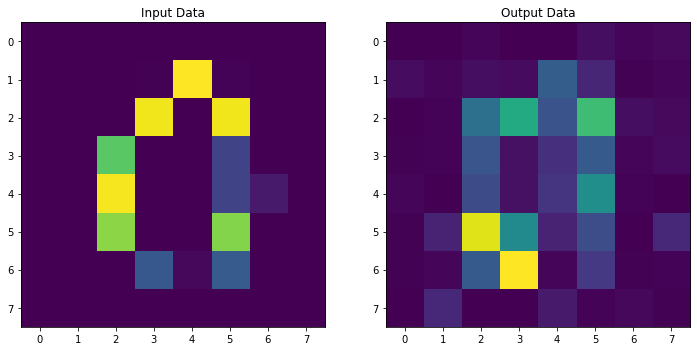

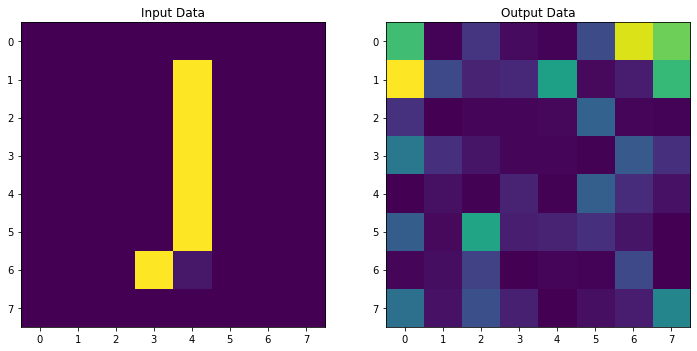

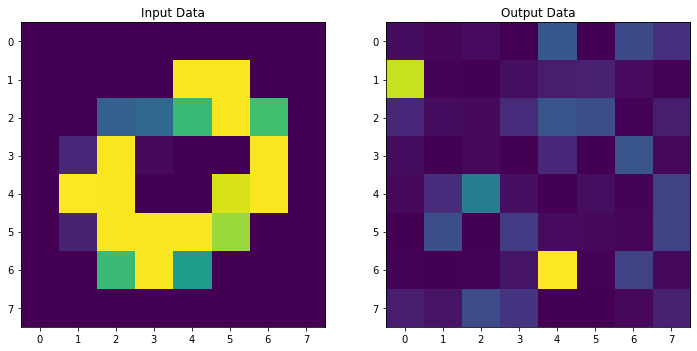

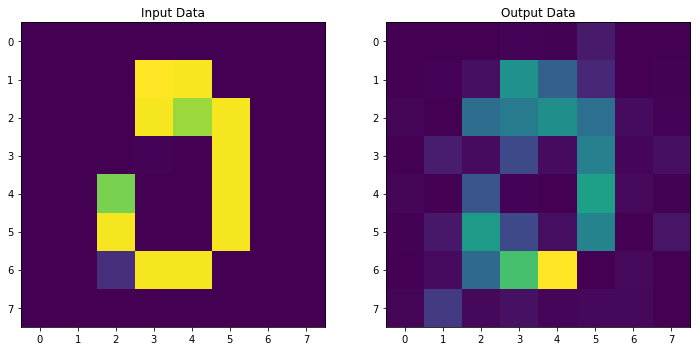

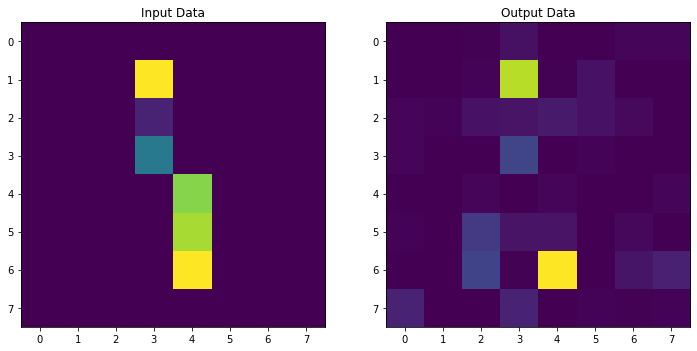

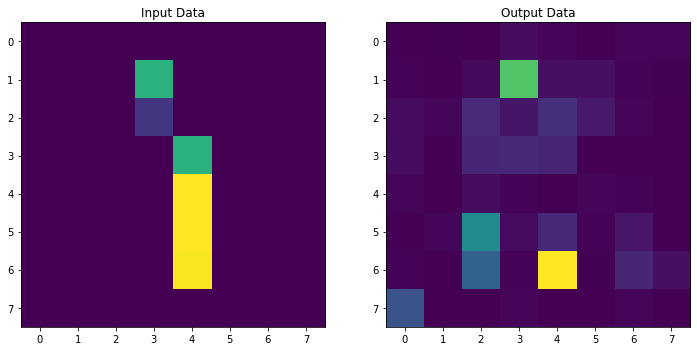

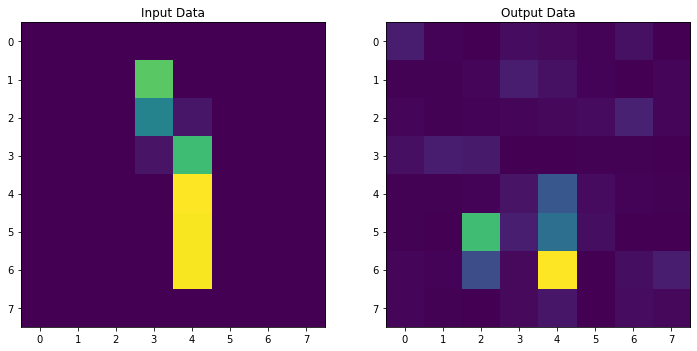

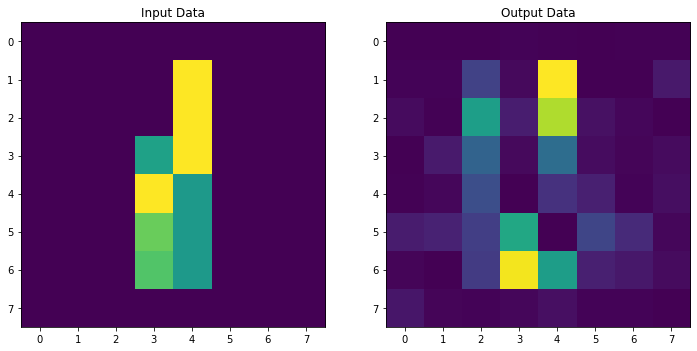

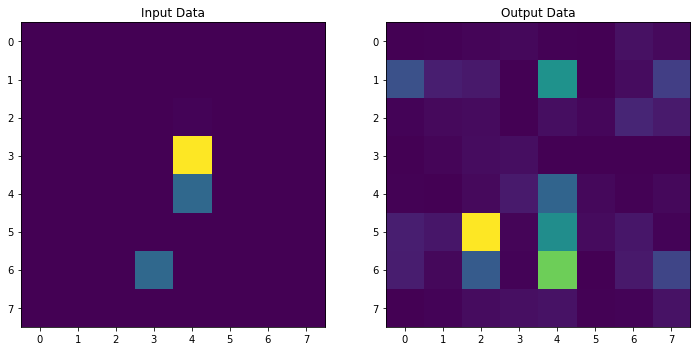

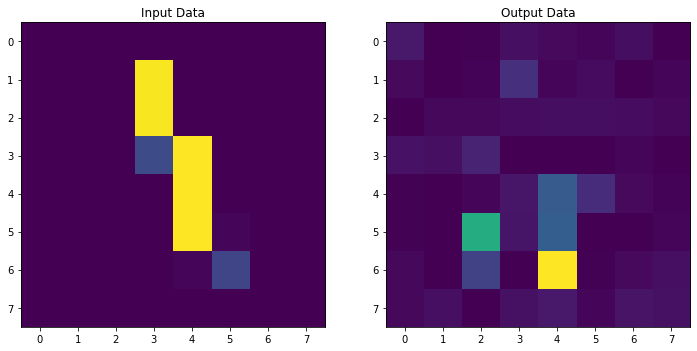

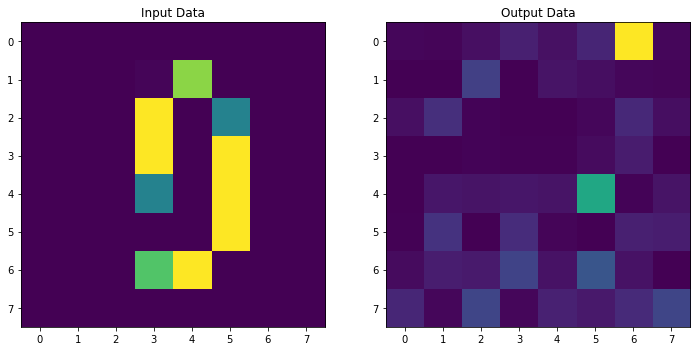

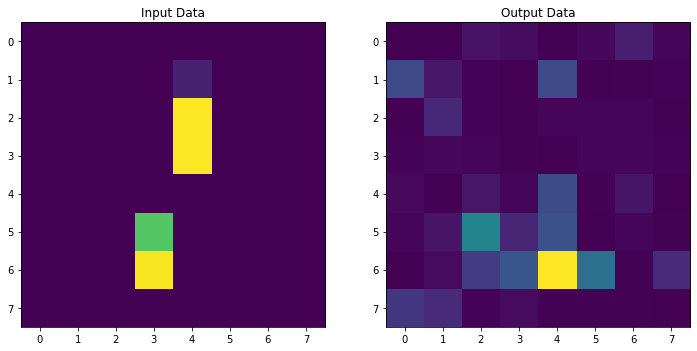

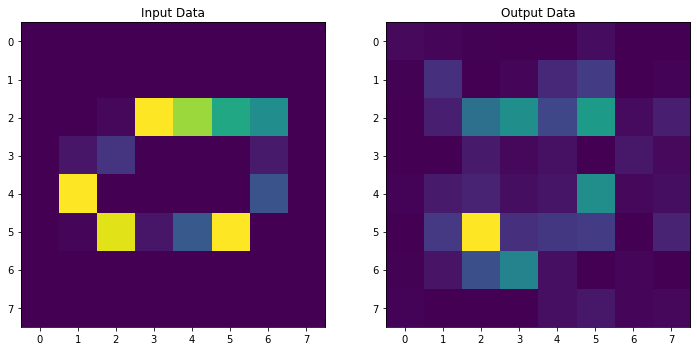

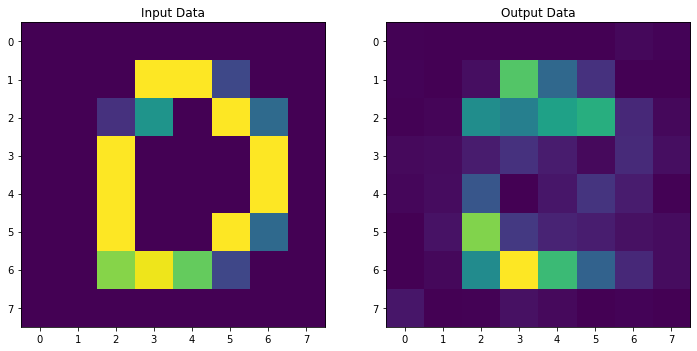

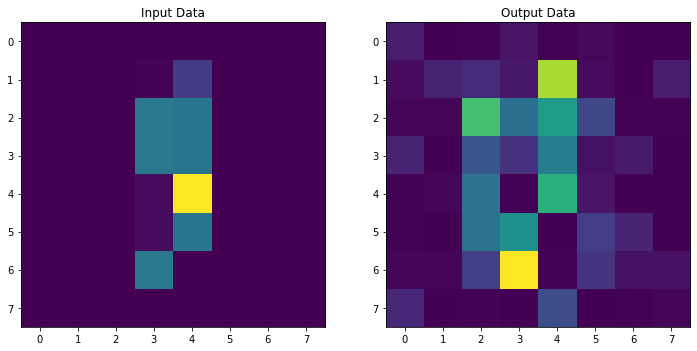

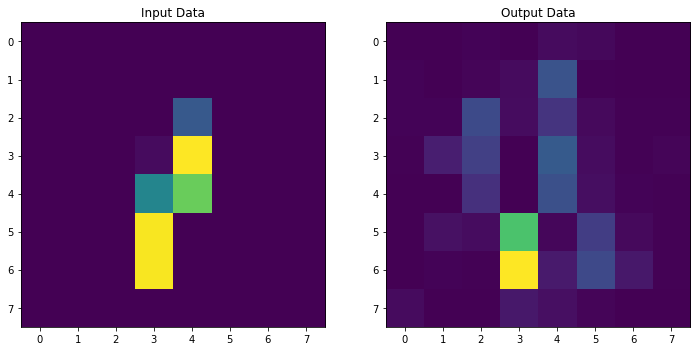

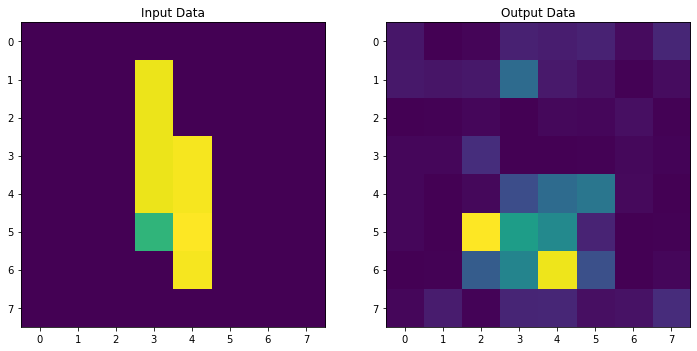

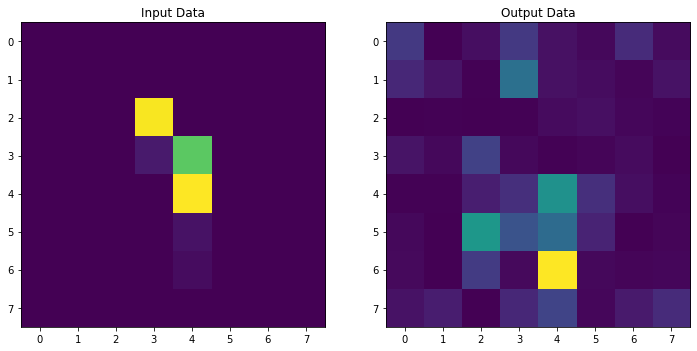

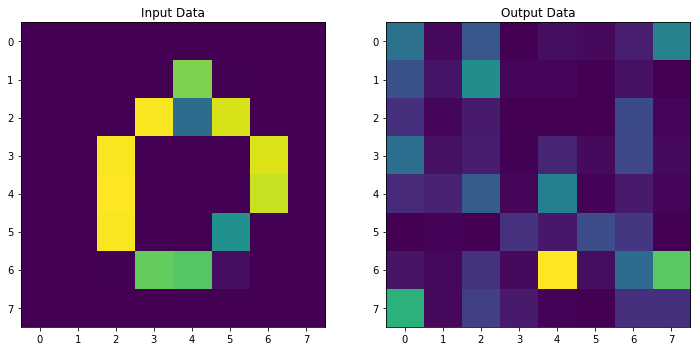

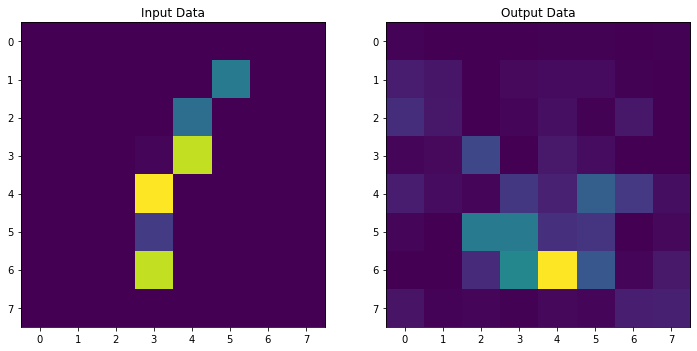

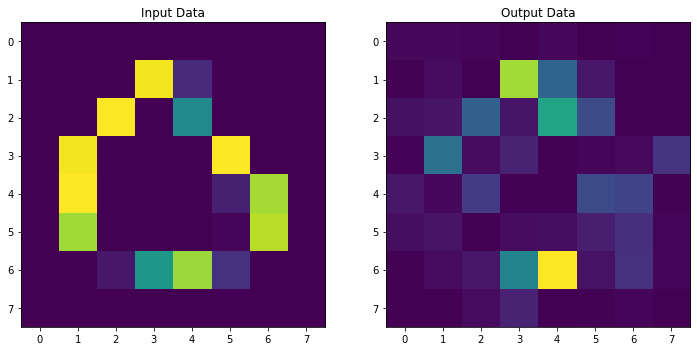

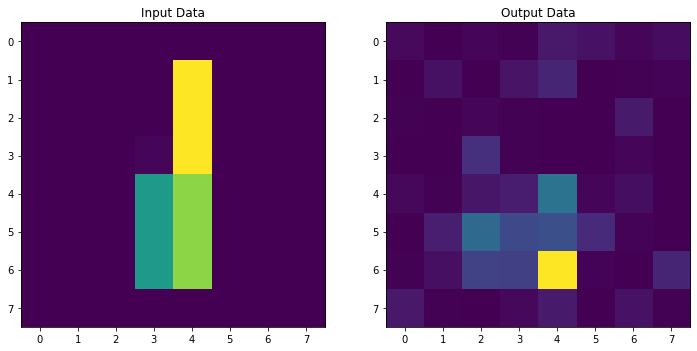

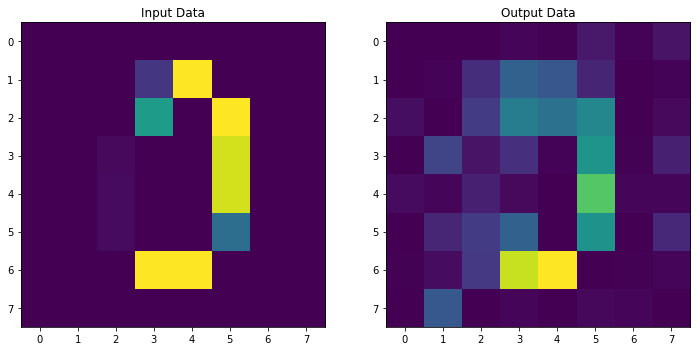

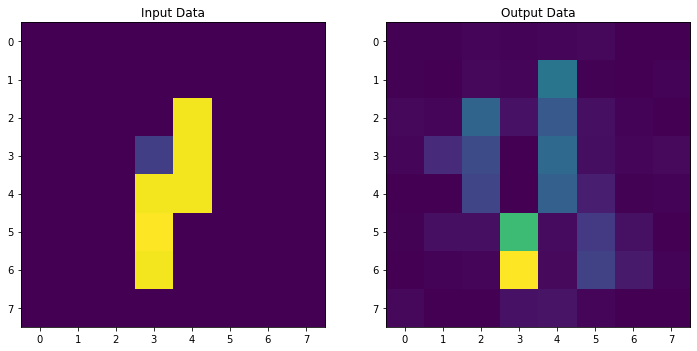

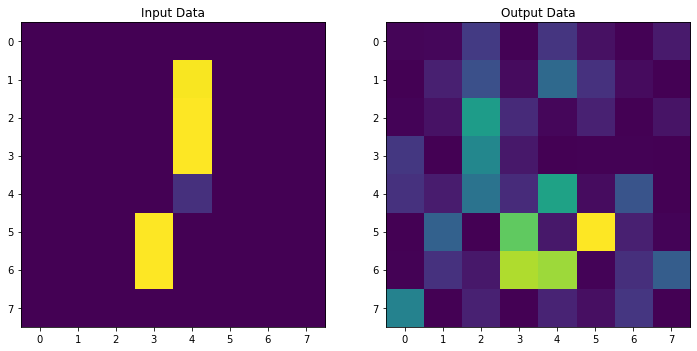

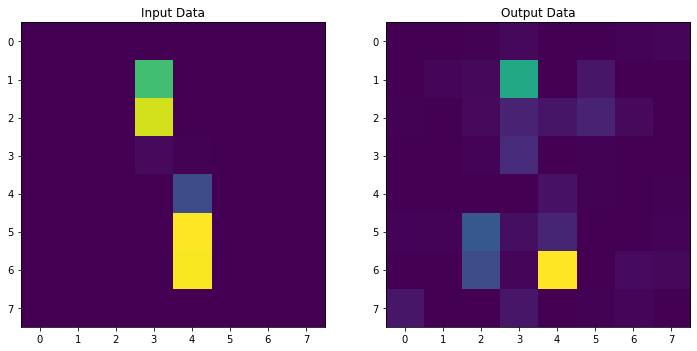

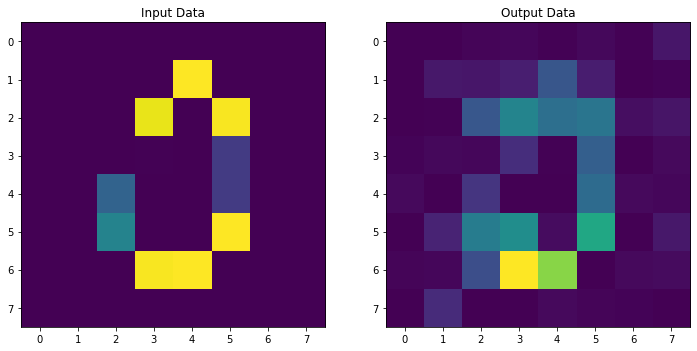

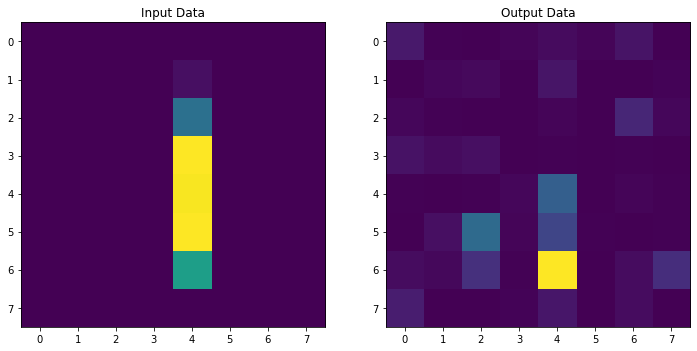

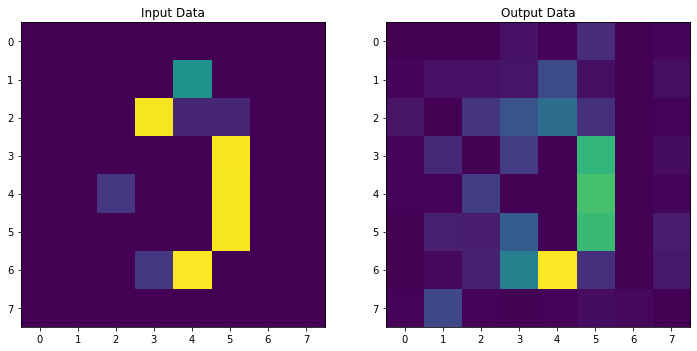

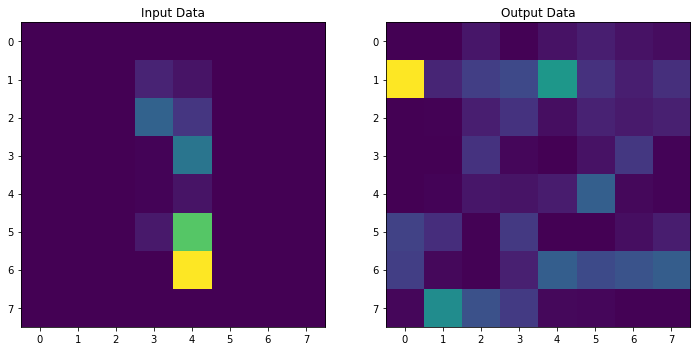

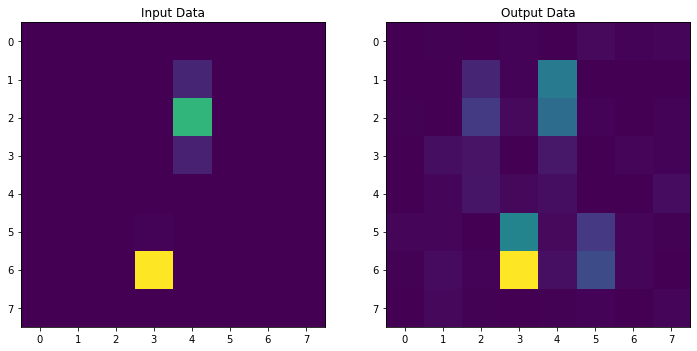

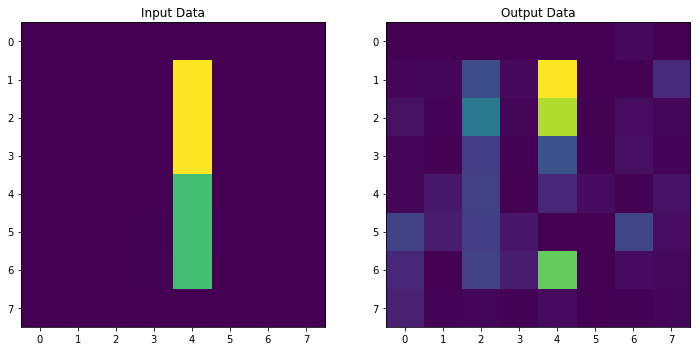

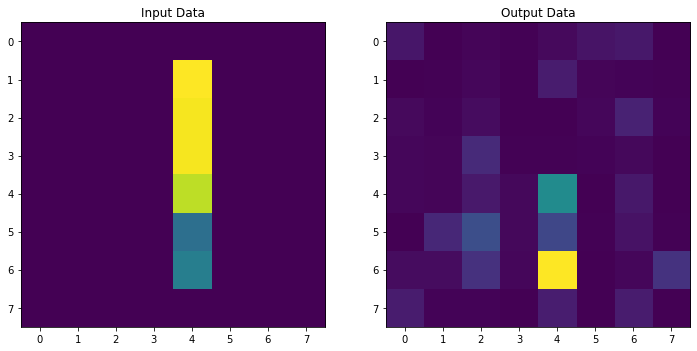

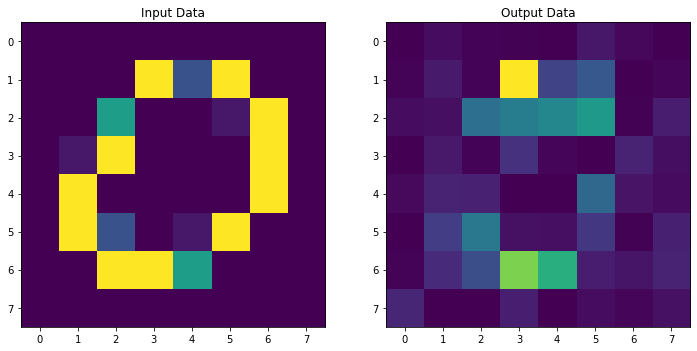

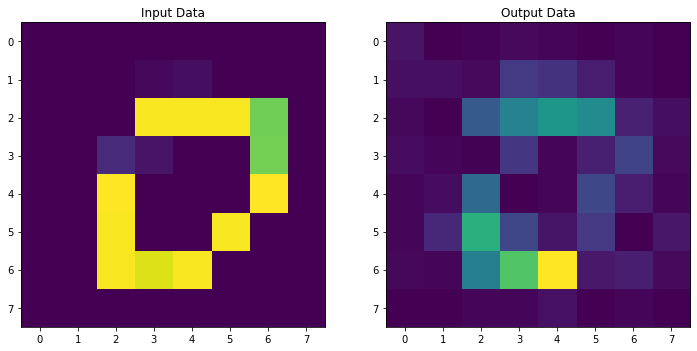

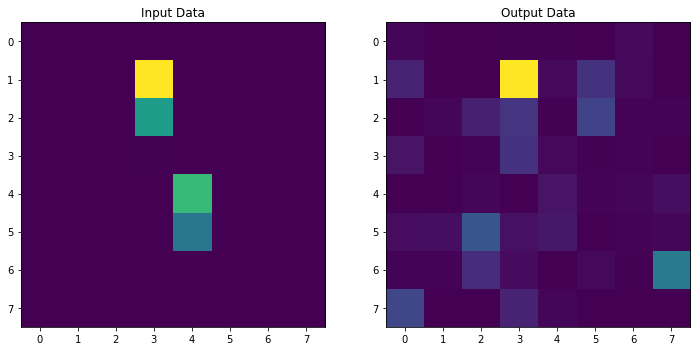

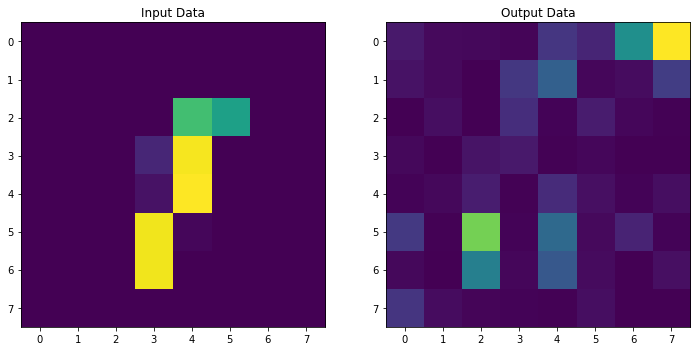

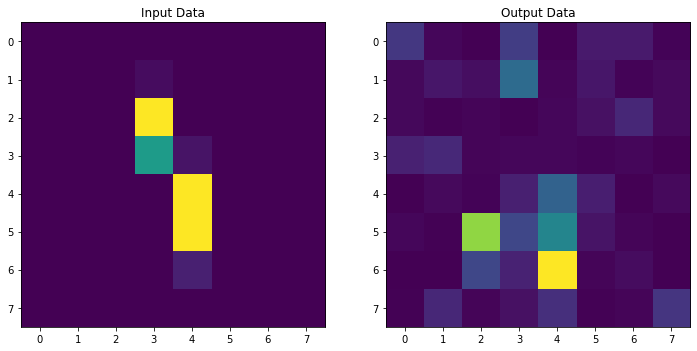

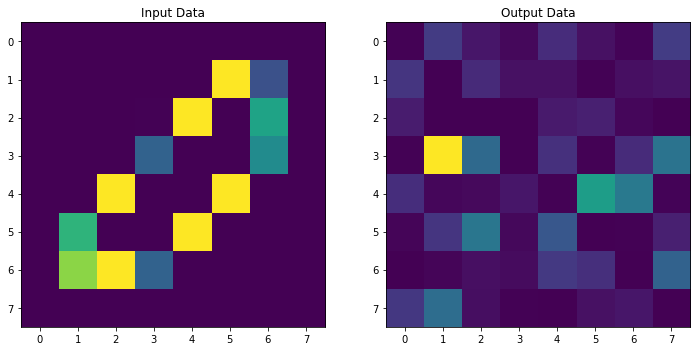

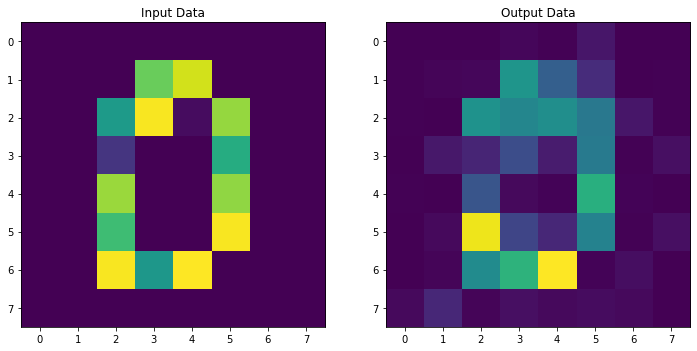

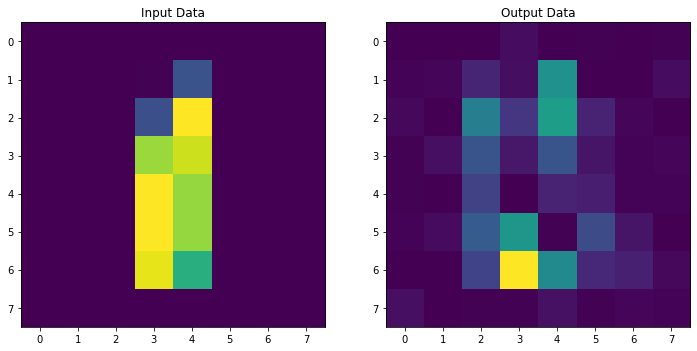

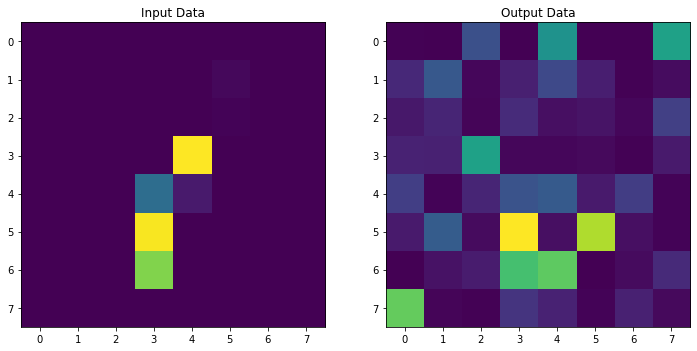

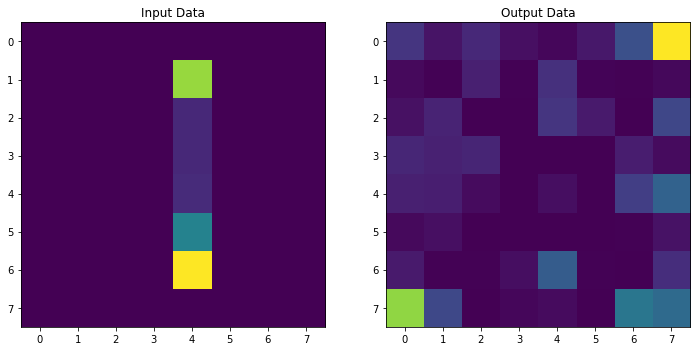

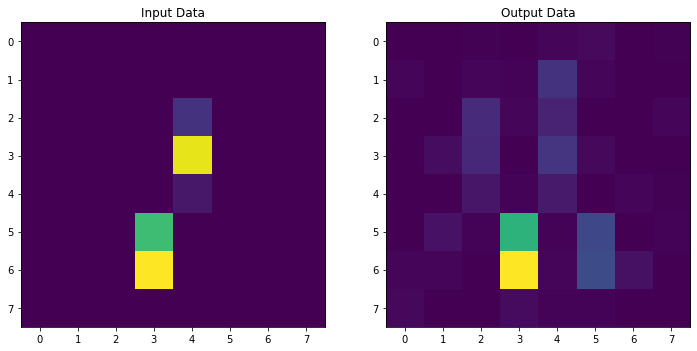

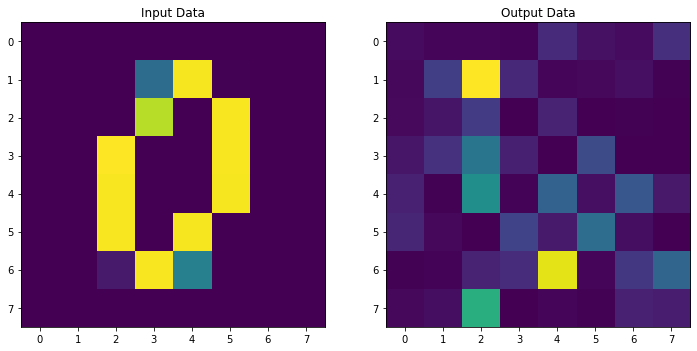

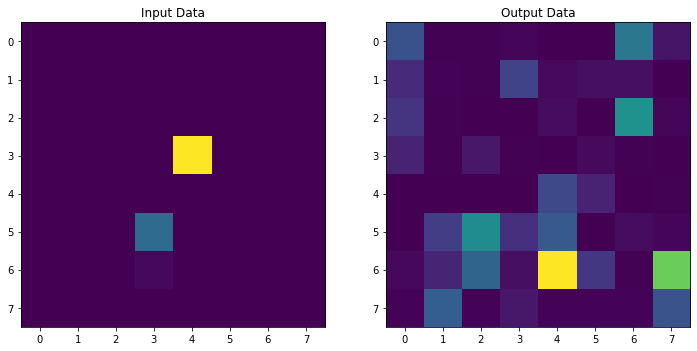

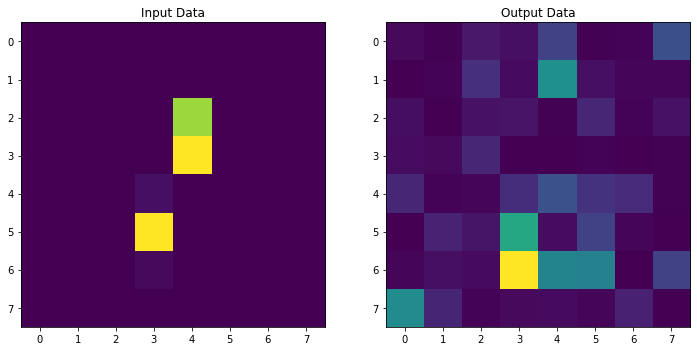

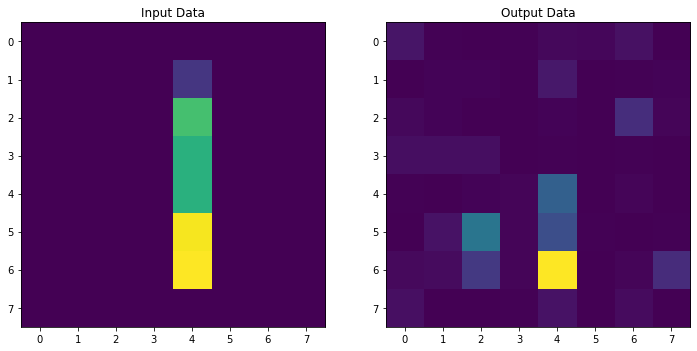

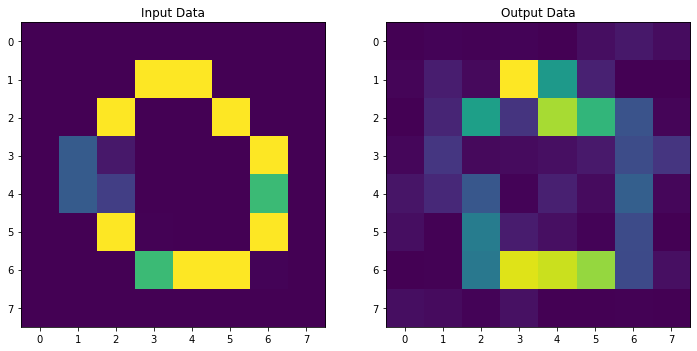

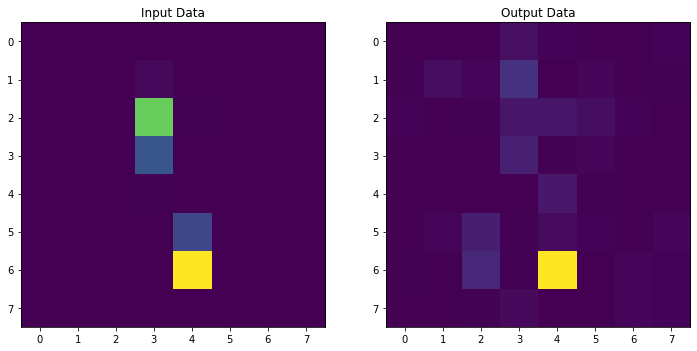

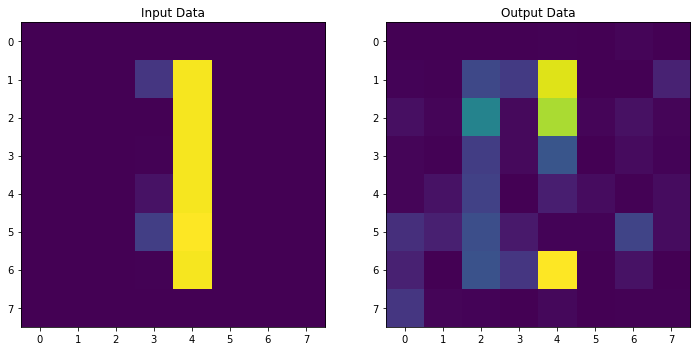

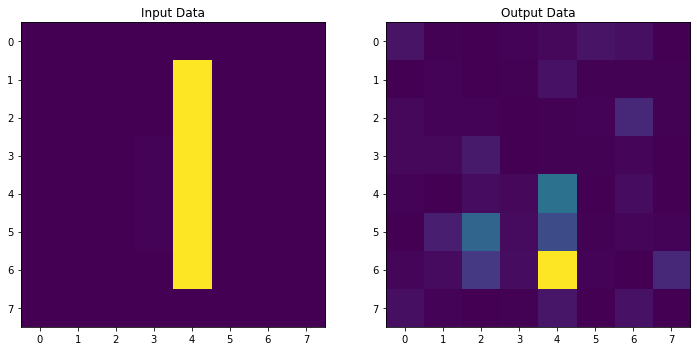

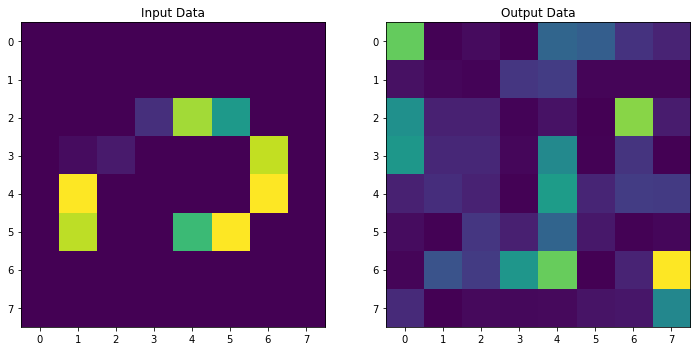

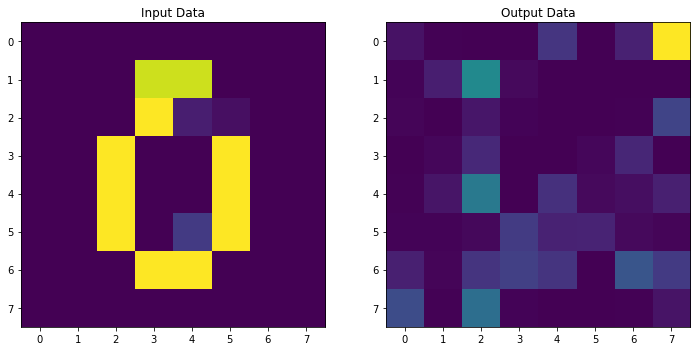

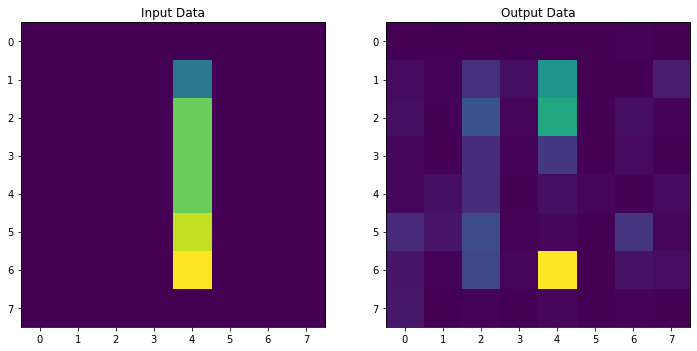

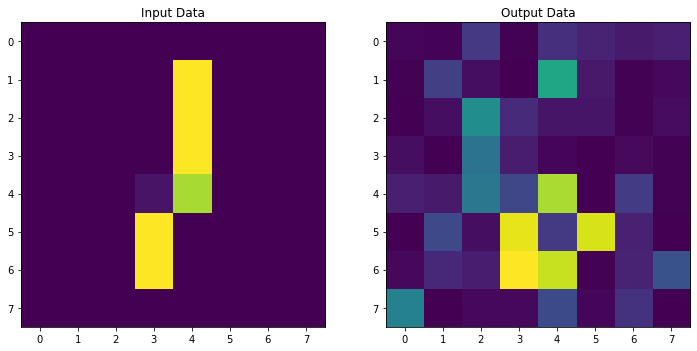

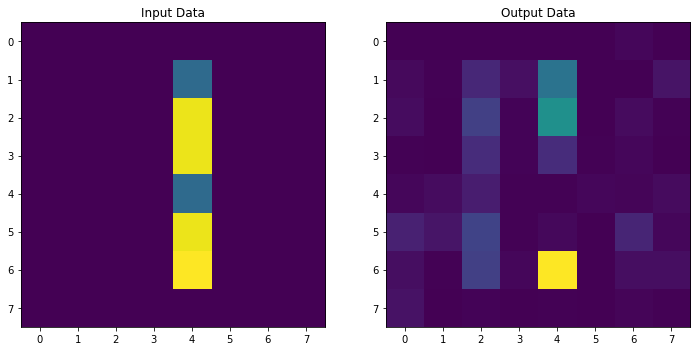

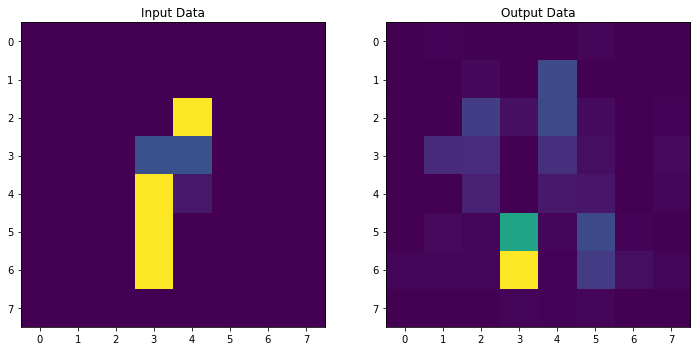

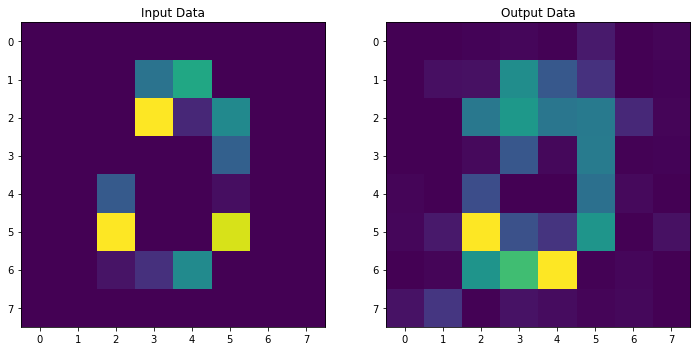

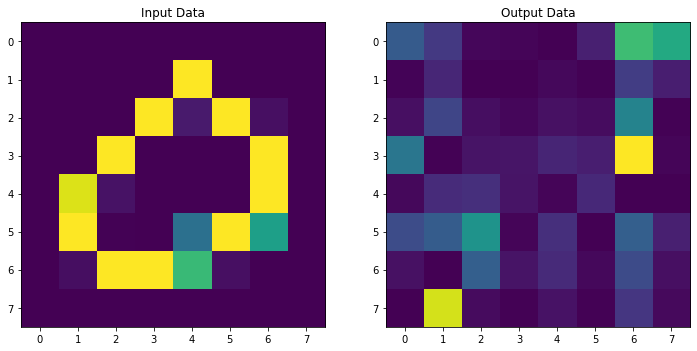

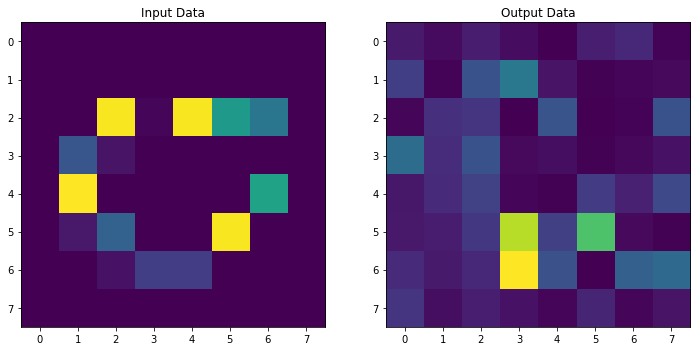

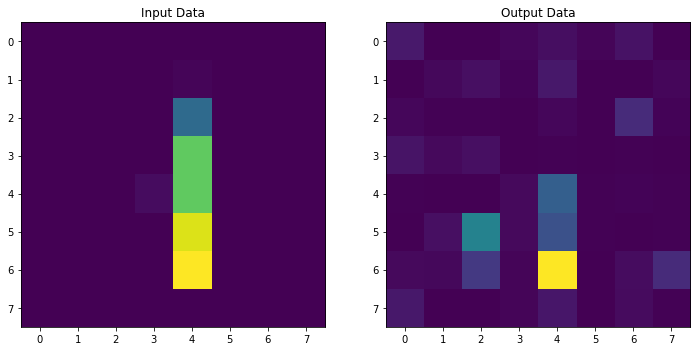

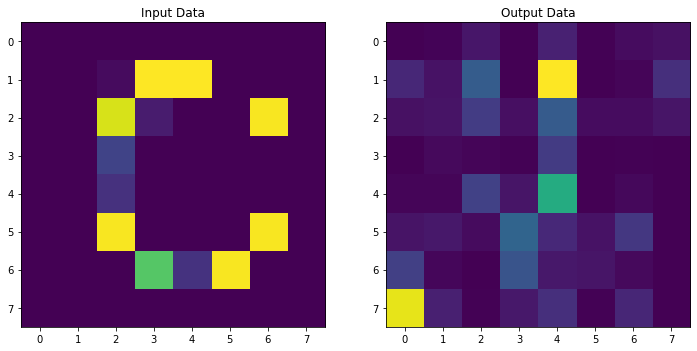

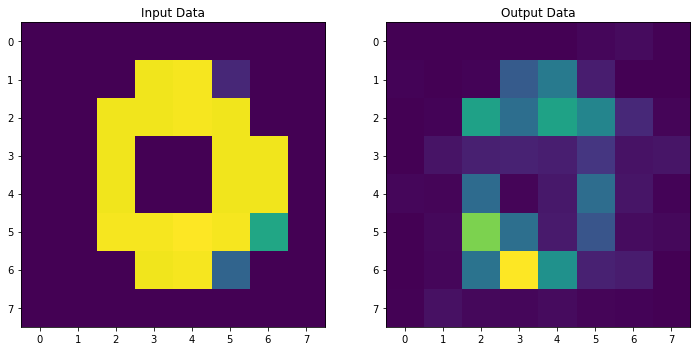

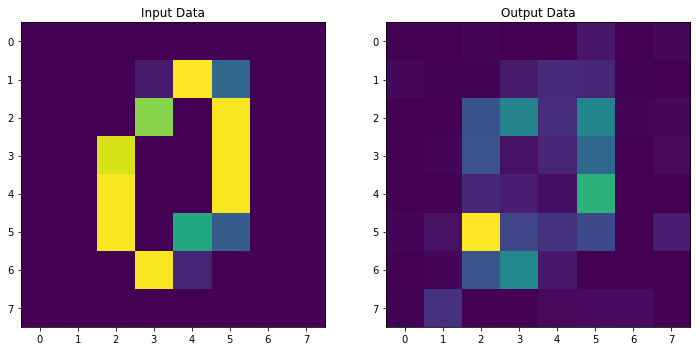

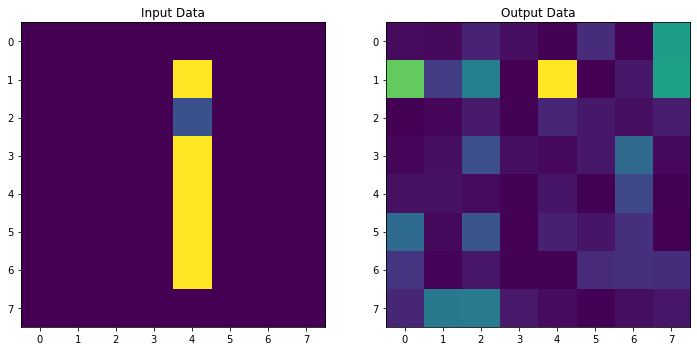

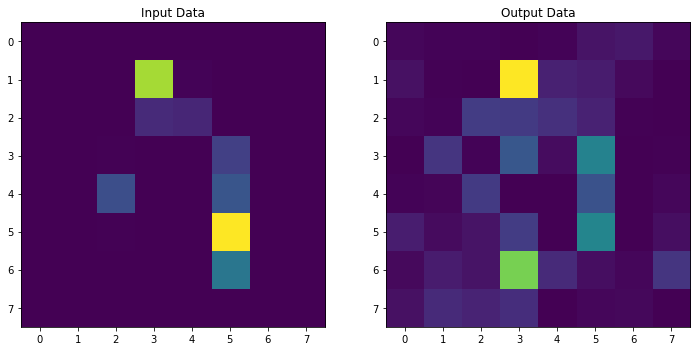

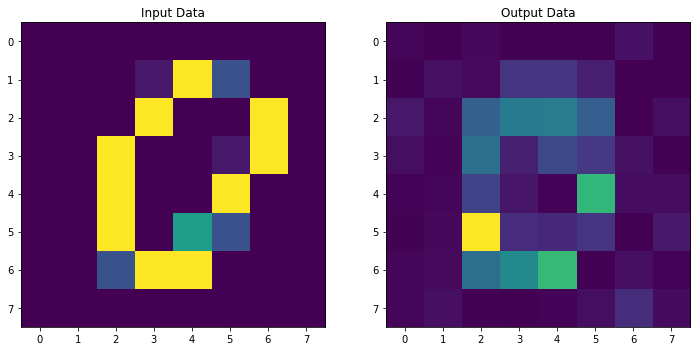

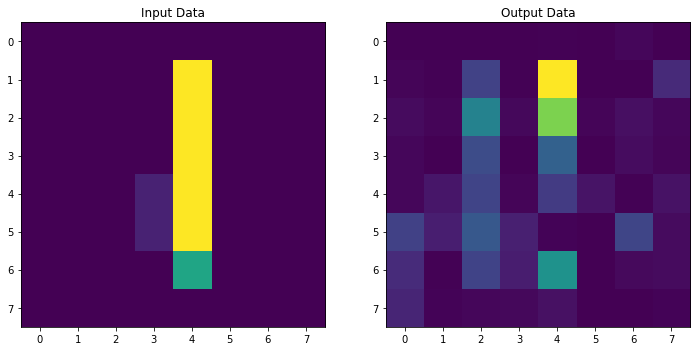

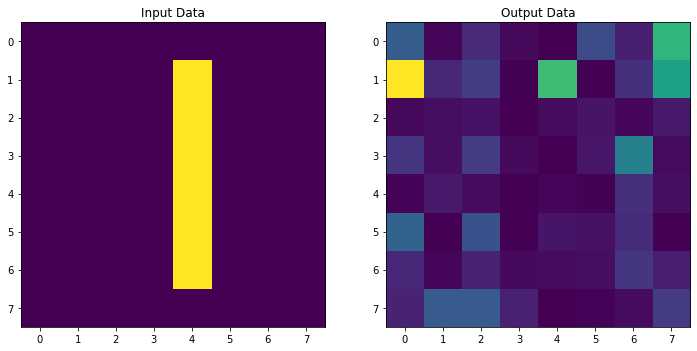

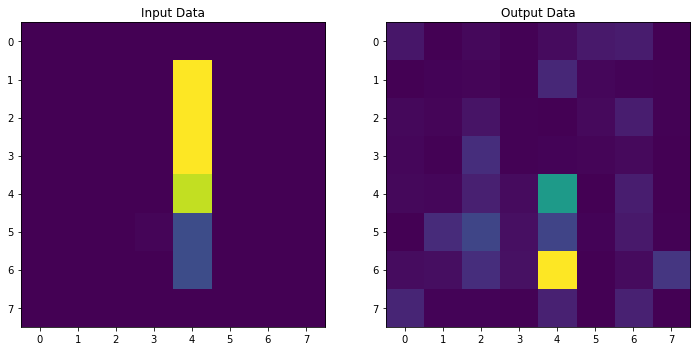

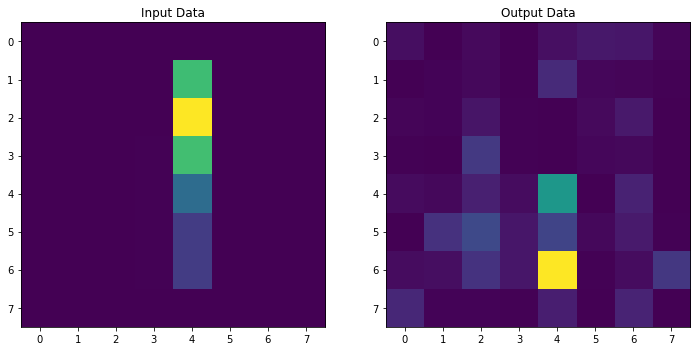

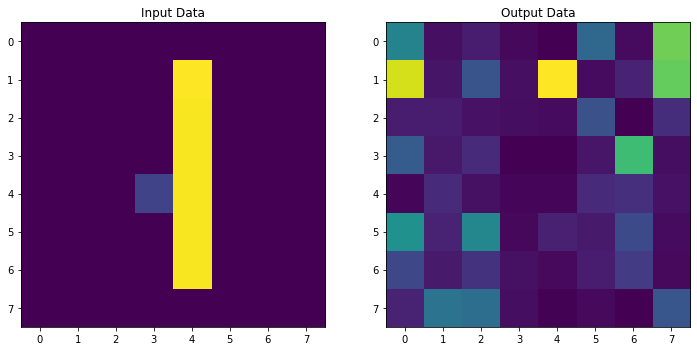

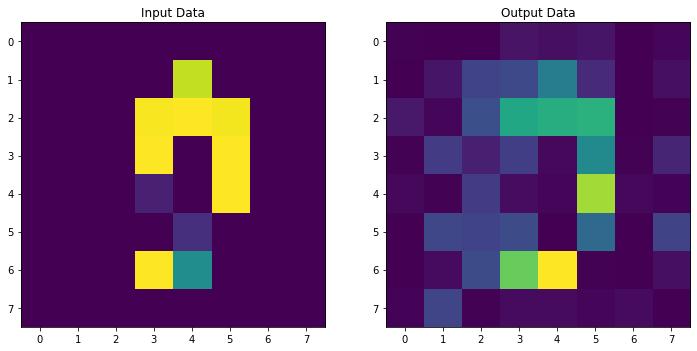

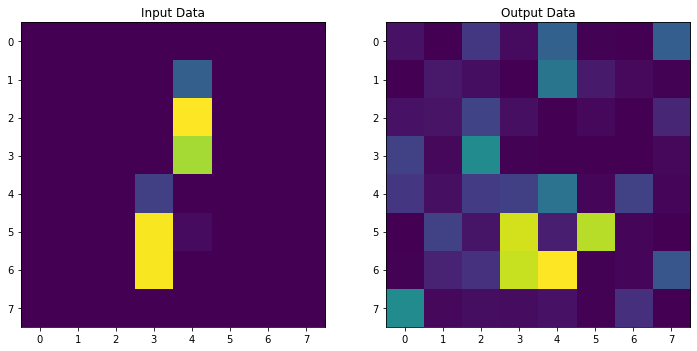

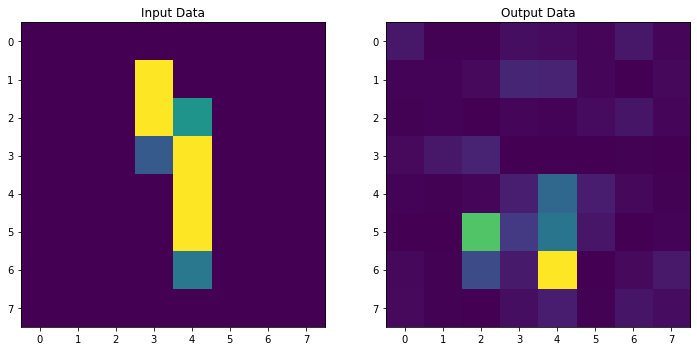

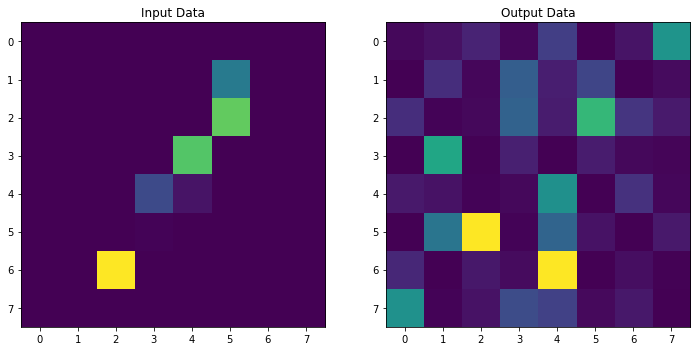

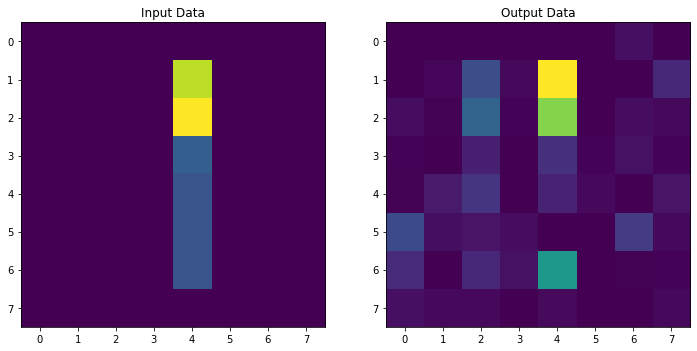

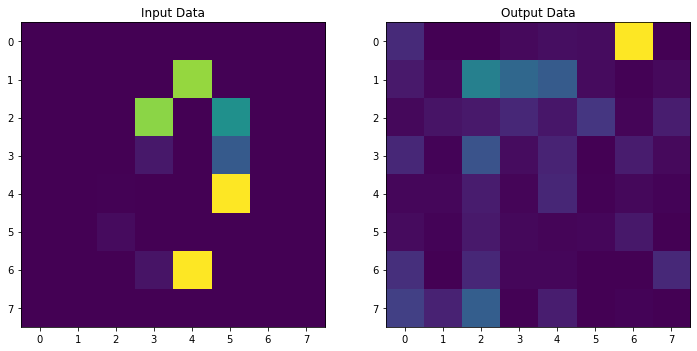

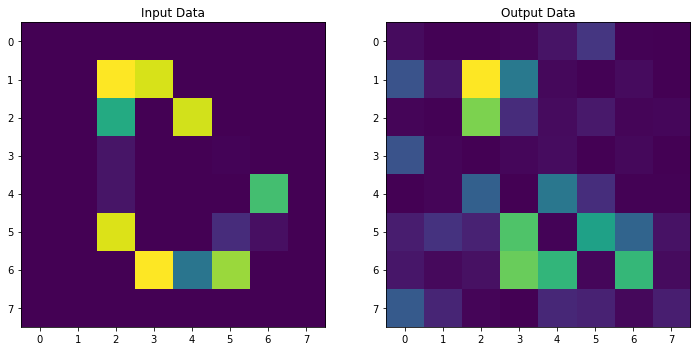

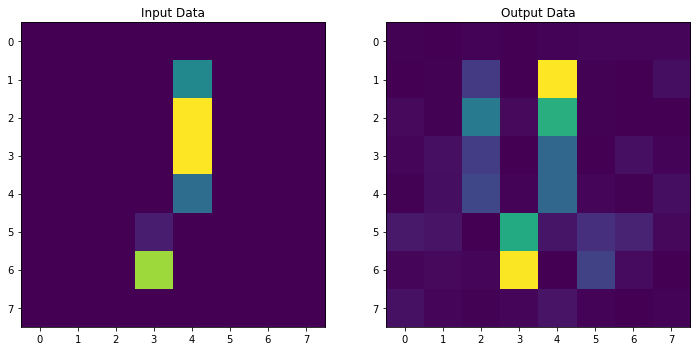

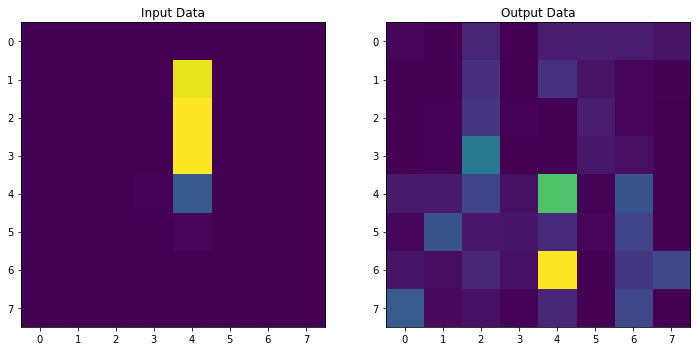

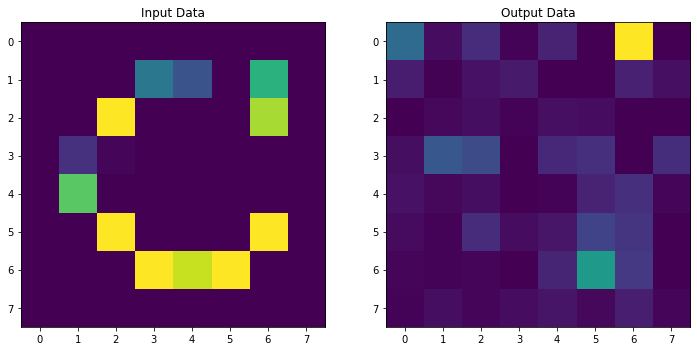

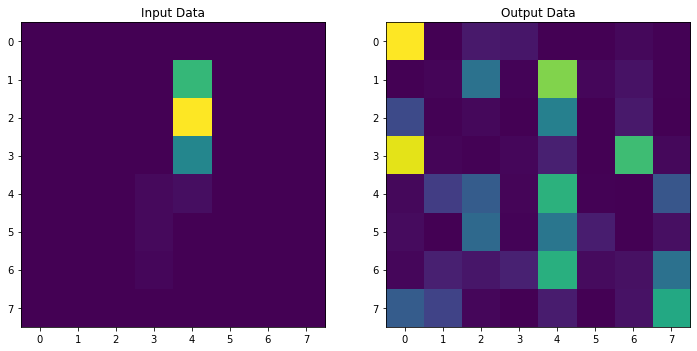

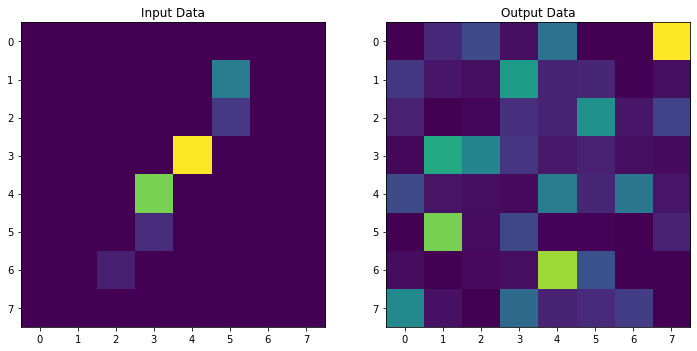

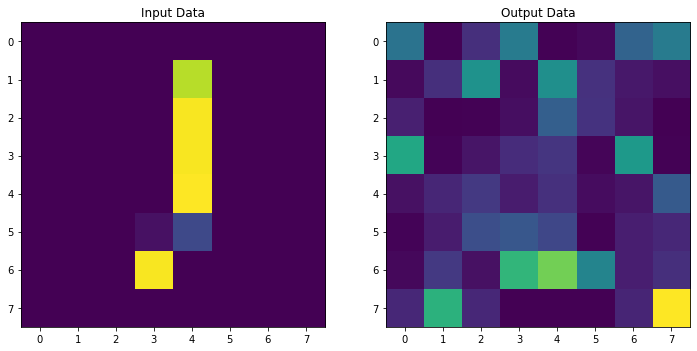

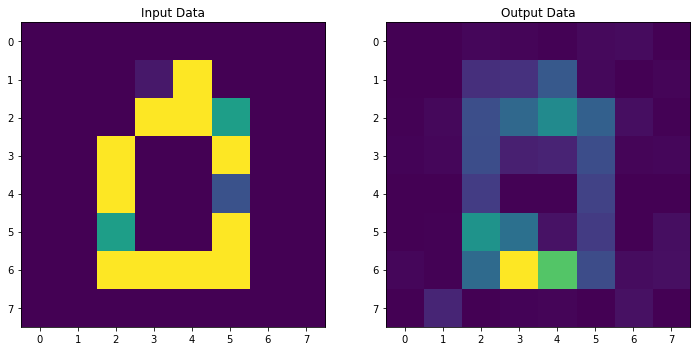

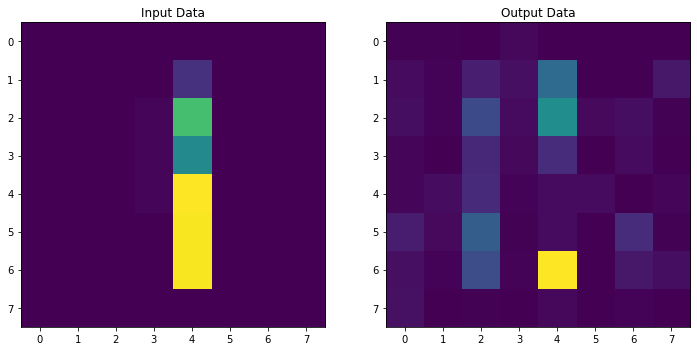

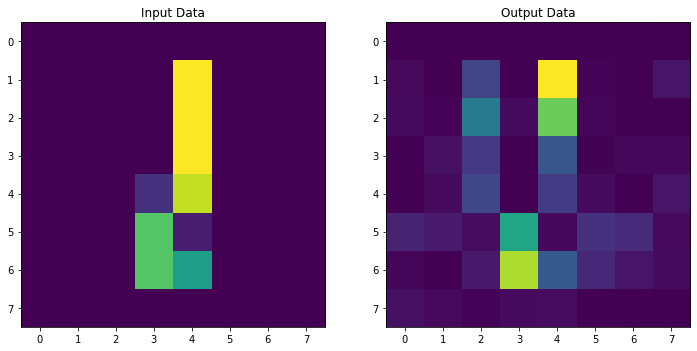

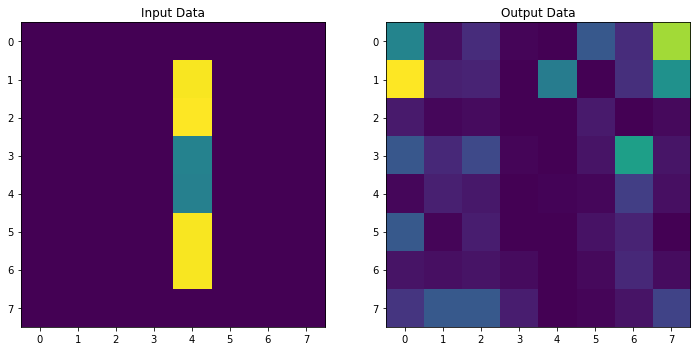

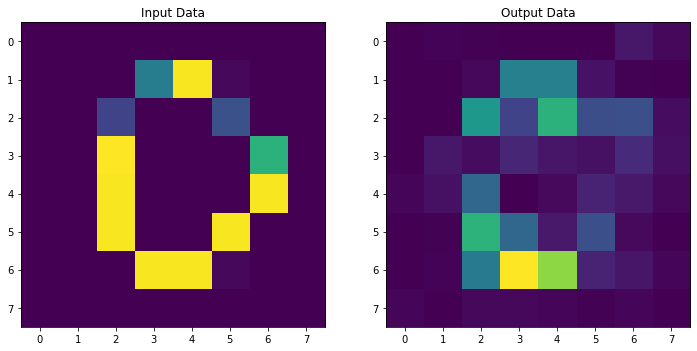

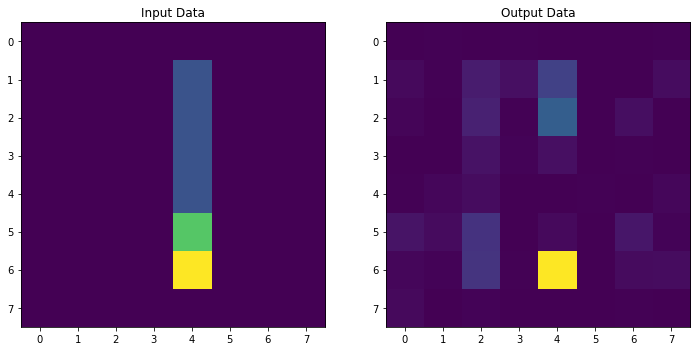

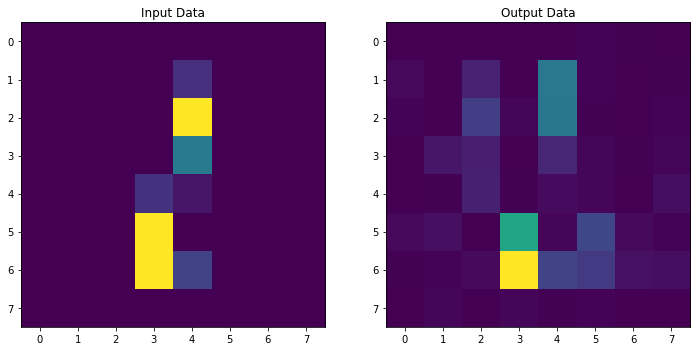

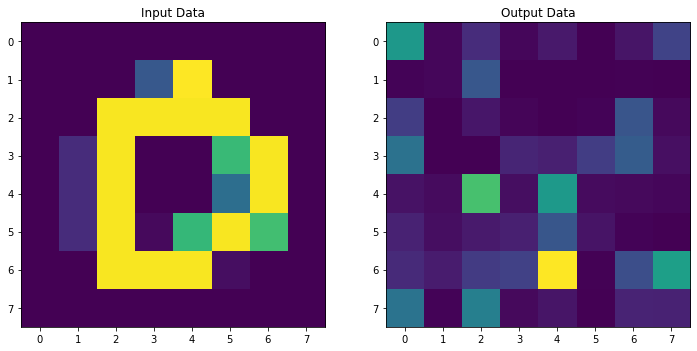

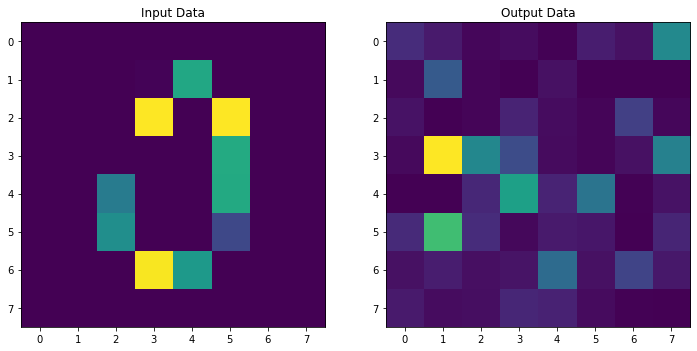

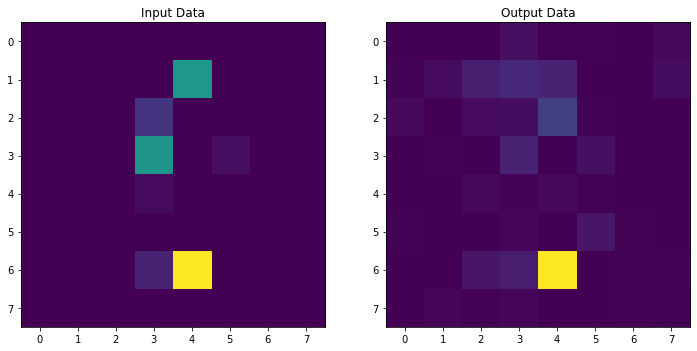

In [18]:
# Testing the model
for image, label in zip(test_images, test_labels):
#     testing input, testing original sample
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 8))
#     testing output, model version of the sample
    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 8))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()